# L5

Ref: C. Bishop "Machine Learning", Ch.1-3

Na tych ćwiczeniach omówimy:
    * bias-variance dillema,
    * modele i estymatory,
    * ewaluację modelów,
    * regularyzację i jej związek z rozumowaniem Bayesowskim. 

In [1]:
# importy, przydatne funkcje

import numpy as np
from matplotlib import pyplot as plt
from sklearn.linear_model import LinearRegression
%matplotlib inline

# np.vander(x, degree + 1)
# przyjmuje listę liczb x
# zwraca tabelę po zmianie zmiennych na wielomian stopnia x
# można sobie przetestować dla lepszego zrozumienia

def f(size):
    '''
    zwraca dwie listy przykładowych danych (x i y) o długości 'size'
    w tym wypadku przykładowa prawdziwa funkcja to y(x) = 2 * sin(1.5 * x)
    '''
    x = np.linspace(0, 4.5, size)
    y = 2 * np.sin(x * 1.5)
    return (x,y)

def sample(size):
    '''
    zwraca dwie listy przykładowych danych (x i y) o długości 'size'
    podobnie jak f, ale z dodanym szumem
    uwaga - współrzędna x jest "losowana" z rozkładu jednostajnego
    (dla naszych zastosowań nie robi to większej różnicy, ale porządni informatycy
    mogą chcieć zastąpić linspace przez prawdziwe losowanie)
    '''
    x = np.linspace(0, 4.5, size)
    y = 2 * np.sin(x * 1.5) + np.random.randn(x.size)
    return (x,y)

def fit_polynomial(x, y, degree):
    '''
    zwraca nauczony model regresji z wielomianową zmianą zmiennych
    (x,y): dane treningowe
    degree: stopień wielomianu
    '''
    # To juz umiemy sami zaimplementować!
    model = LinearRegression()
    model.fit(np.vander(x, degree + 1), y)
    return model

def apply_polynomial(model, x):
    '''
    zwraca predykcję nauczonego modelu regresji z wielomianową zmianą zmiennych
    x: dane do predykcji
    '''
    degree = model.coef_.size - 1 # wyciągamy stopień wielomianu z modelu
    y = model.predict(np.vander(x, degree + 1))
    return y

f_x, f_y = f(50) # tym narysujemy sinusa

## Koncept: dane to losowa próbka

* Dane pochodzą z pewnego rozkładu prawdopodobieństwa (łącznego).
* Nie znamy tego rozkładu, chcemy się go nauczyć.
* Rozkład nie zmienia się w czasie (a więc nasza wiedza z teraz będzie aktualna zawsze).

<img width=400 src="figures/L5/the-seventh-seal-chess-game.jpg">

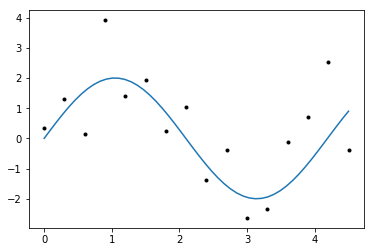

In [2]:
# Przykładowe dane, z których próbujemy się nauczyć prawdziwego rozkładu prawdopodobieństwa
x, y = sample(16)
plt.plot(x, y, 'k.')
plt.plot(f_x, f_y)

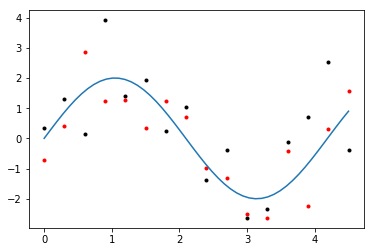

In [3]:
# Inny zbior danych, ale pochodzący z tego samego rozkładu!
prev_x, prev_y = x, y
x, y = sample(16)
plt.plot(prev_x, prev_y, 'k.', color='black')
plt.plot(x, y, 'k.', color='r')
plt.plot(f_x, f_y)

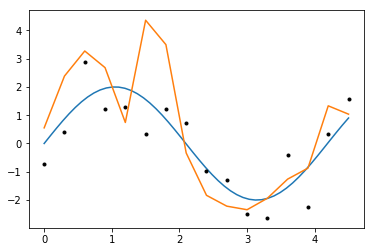

In [4]:
# Tu sie dopasowalismy
X_train, y_train = sample(16)
overfitted_model = fit_polynomial(X_train, y_train, 15)
p_y = apply_polynomial(overfitted_model, X_train)
plt.plot(f_x, f_y)
plt.plot(X_train, y, 'k.')
plt.plot(X_train, p_y)

## Bias-variance tradeoff

Na wykładzie (notebook o nazwie mum2017_2_regr.ipynb) poznaliśmy tzw. bias-variance dilemma (lub bias-variance tradeoff). Przypomnijmy, o co w tym chodzi.

### Model jako zmienna losowa

Oznaczmy wszystkie nasze dane treningowe przez

$$D = [(\mathbf{x_1}, y_1), (\mathbf{x_2}, y_2), \ldots, (\mathbf{x_N}, y_N)].$$

Jeśli pary $(\mathbf{x}, y)$ pochodzą z rozkładu łącznego $p(\mathbf{x}, y)$, to zestawy danych $D$ pochodzą z rozkładu produktowego - produktu $N$ niezależnych rozkładów:

$$ p(D) = p(\mathbf{x_1}, y_1, \mathbf{x_2}, y_2, \ldots, \mathbf{x_N}, y_N) = p(\mathbf{x_1}, y_1)p(\mathbf{x_2}, y_2) \ldots p(\mathbf{x_N}, y_N) $$

Jeśli potraktujemy model regresji liniowej (konkretnie metodę model.fit) jako funkcję, która zwraca wagi $\mathbf{w}$ na podstawie danych $D$, to w tym sensie model jest zmienną losową. Możemy też od razu myśleć o modelu jako o funkcji, która przyjmuje dane $D$ i zwraca **funkcję** zadaną wzorem $y(\mathbf{x}) = <\mathbf{w}|\mathbf{x}>$.

### Ważna (subtelna?) uwaga

W praktyce mamy jeden zestaw danych $D$. Ale moglibyśmy mieć inny zestaw danych - powyżej wypisaliśmy formalnie rozkład prawdopodobieństwa na wszystkich możliwych zestawach danych. Dlatego jeśli chcemy ocenić model (model jako algorytm uczenia, nie jako nauczony zestaw wag!), to interesuje nas bardziej jego średnia skuteczność dla wszystkich możliwych zestawów danych $D$, a nie tylko dla tego konkretnego $D$, które posiadamy.

### Składowe błędu

Zakładamy, że istnieje prawdziwa funkcja $y(\mathbf{x})$, którą chcemy znaleźć modelem regresji liniowej, obserwując dane $D$. Funkcja nauczona z danych różni się od funkcji prawdziwej, a błąd ma trzy składniki:
* bias - jeśli dla różnych $D$ model **średnio** uczy się nieprawdziwej funkcji, to odległość tej średniej od prawdziwej funkcji $y$ nazywana jest biasem,
* variance - jeśli dla różnych $D$ model uczy się bardzo podobnych funkcji, to variance jest mała, jeśli natomiast nauczona funkcja bardzo zależy od konkretnego $D$ (czyli model zapamiętuje dane, overfituje, nie rozumie rozkładu prawdopodobieństwa), to variance jest duża,
* noise - szum dodany do prawdziwej funkcji.

Noise jest od nas niezależny, więc nie możemy go redukować, natomiast, w miarę możliwości, chcielibyśmy zmniejszyć bias i variance do zera. Okazuje się jednak, że znane nam techniki zmniejszania biasu powodują zwiększenie variance i na odwrót. Cała sztuka polega na znalezieniu złotego środka, gdzie **suma** bias + variance jest najmniejsza, a więc nasza predykcja najdokładniejsza.

## Ewaluacja 

Ewaluacja polega na ocenie, jak nauczony model będzie sobie radził na nowych danych, czyli jak dobrze opisuje prawdziwą funkcję $y(\mathbf{x})$ wszędzie, a nie tylko na $D$. 

### Funkcja kosztu

Wiemy już, że model regresyjny uczy się rozkładów $p(y\mid \mathbf{x})$. Wygodnie jest oceniać poprawność modelu jedną liczbą, dlatego też używa się tzw. funkcji kosztu. Najpopularniejszą funkcją kosztu w problemach regresji jest błąd średniokwadratowy - znamy jego związek z estymatorem ML.

Funkcję kosztu oznaczamy literą $L$.

Ale można też definiować inne funkcje kosztu. Muszą one tylko spełniać następujące warunki:
* argumentami $L$ są dwie rzeczy: prawdziwa etykieta $y$ i predykcja modelu,
* wartości funkcji $L$ są nieujemnymi liczbami rzeczywistymi,
* jeśli predykcja jest poprawna, to koszt powinien wynosić zero,
* "lepiej" nauczony model powinien średnio mieć niższe wartości funkcji kosztu na nowych danych.

Przykład: definiujemy $L(y_{true}, y_{pred}) = (y_{true} - y_{pred})^2$ (błąd średniokwadratowy). Jeśli prawdziwe etykiety to $(1, 3, 4)$, a predykcje to $(2, 4, 4.5)$, to średni błąd wynosi $\frac13 ((1-2)^2 + (3-4)^2 + (4-4.5)^2)) = \frac34$.

Uwaga: to nie funkcja kosztu mówi, który model jest lepiej nauczony. To my musimy ustalić kryterium "lepszości" poprzez definicję funkcji kosztu. Wygląda to jak błędne koło - po co w takim razie w ogóle używać funkcji kosztu? [odpowiedź na zajęciach]

### Cel uczenia z funkcją kosztu

Naszym celem jest minimalizacja średniej funkcji kosztu, co zapisujemy następująco:

$$ \mbox{Expected loss} = \mathbb{E}[L] = \int \int L(y, f(\mathbf{x})) p(\mathbf{x},  y) d\mathbf{x} dy $$


## Cwiczenie 0 [0 pkt] 

(Do zrobienia przed przejściem dalej)

Jaki ``Expected loss`` będzie miał model "overfitted_model"?

Hint: mamy możliwość samplowania punktów z rozkładu $p(\mathbf{x},  y)$

In [5]:
m = overfitted_model
x, y_true = sample(370)

y_pred = apply_polynomial(m, x)
((y_true - y_pred)**2).sum() / len(x)

31.188517835327485

$p(\mathbf{x},  y)$ to prawdziwy rozkład, z którego pochodzą dane. W praktyce nie znamy go, więc nie możemy policzyć tej całki, nawet znając funkcję $f$ (tu $f$ oznacza model.predict).

Pytanie: jak w takim razie dobrze **aproksymować** ``Expected loss`` ?

## Założenie i.i.d.

Założenie i.i.d. mówi, że:
* każda para $(\mathbf{x}, y)$ jest losowana niezależnie od pozostałych (tak jak np. rzut monetą, nie tak jak np. cena akcji na giełdzie, która zależy bardzo silnie od danych historycznych),
* prawdziwy rozkład się nie zmienia.

W prostych problemach zawsze zakładamy i.i.d. W trudnych problemach albo zakładamy i.i.d. i mamy nadzieję, że wyniki wciąż będą sensowne (z reguły tak nie jest), albo musimy pokombinować.

Póki co wszystko będzie i.i.d.

## Aproksymacja Expected loss - Test set

Wygenerowanie nowych danych jest kosztowne i czasochłonne [macie Państwo dobre przykłady?], więc nie możemy działać tak, jak w ćwiczeniu 0. Musimy sprytnie wykorzystać tylko te dane, które już posiadamy. Założenie i.i.d. pozwala sensownie estymować ``Expected loss`` w opisany poniżej sposób.

Skoro nasze dane są i.i.d., to znaczy że jeśli podzielimy je 2 losowe podzbiory: zbiór treningowy (X_train, y_train) oraz zbiór testujący/testowy (X_test, y_test), to:
* każdy z tych zbiorów będzie i.i.d.
* oba te zbiory łącznie/wzajemnie będą i.i.d.

Jeśli podczas uczenia model zobaczy tylko zbiór treningowy, to średni błąd na zbiorze testującym:

$$\mbox{Empirical loss} = \frac1N \sum_{i=1}^{N} L(y_i, f(\mathbf{x_i})) $$

będzie **estymatorem** ``Expected loss``.

## Estymator - definicja, jego bias i variance

Aby policzyć ``Expected loss`` musielibyśmy znać wszystkie możliwe pary $y_{true}, y_{pred}$ wraz z prawdopodobieństwem ich wystąpienia - takich par jest nieskończenie wiele.

Estymator jest funkcją, która przyjmuje skończenie wiele takich par, wylosowanych z rozkładu - listę par oznaczamy $D$. Wartością estymatora jest ``Expected loss`` **estymowany** z danych $D$. Sposób estymacji zadany jest wzorem funkcji.

W powyższym przykładzie ``Empirical loss`` zdefiniowany jest na zbiorze danych długości $N$. Formalnie dla różnych $N$ otrzymujemy definicje różnych estymatorów (czyli $N$ jest stałą, a $D$ zmienną). W ćwiczeniu 0. różnica polegała na tym, że mogliśmy bez większych przeszkód zwiększać $N$. 

Estymator **nie** jest modelem, ale nic nie stoi na przeszkodzie, żeby i tu zobaczyć bias-variance tradeoff. Jest to o tyle ważne, że zawsze chcemy mieć jak najlepszy estymator, aby dobrze ocenić, jak nauczył się nasz model - znowu musimy znaleźć złoty środek.

### Estymator jako zmienna losowa

Załóżmy, że mamy już nauczony model i teraz chcemy go testować na nowych danych. Oznaczmy te dane znowu przez $D$ - to nie są te same dane, co te użyte przy trenowaniu, ale ich własności są niemalże takie same, dlatego pozostańmy przy tym oznaczeniu.

Jeśli pary $(y_{true}, y_{pred}) = (y_{true}, \mathrm{model.predict}(\mathbf{x}))$ pochodzą z rozkładu łącznego $p(y, \mathbf{x})$ (a pochodzą, bo nauczony model jest deterministyczny i jednoznacznie przerabia $\mathbf{x}$ na $y_{pred}$), to zestawy danych $D$ pochodzą z rozkładu produktowego - produktu $N$ niezależnych rozkładów $p$ ("true" i "pred" piszę tu w górnym indeksie, żeby na dole było miejsce na numer obserwacji):

$$ p(D) = p(y^{true}_1, y^{pred}_1, y^{true}_2, y^{pred}_2, \ldots, y^{true}_N, y^{pred}_N) = p(y^{true}_1, y^{pred}_1)p(y^{true}_2, y^{pred}_2) \ldots p(y^{true}_N, y^{pred}_N) $$

Skoro $D$ jest wybierane losowo, to estymator jest zmienną losową (w zależności od $D$ ten sam wzór raz wyestymuje lepiej, a raz gorzej). Możemy teraz powtórzyć dla niego rozkład bias-variance-noise.

### Składowe błędu

Dla nauczonego modelu istnieje prawdziwa średnia wartość funkcji kosztu $L$. Chcemy, aby estymator zwrócił właśnie tę wartość dla dowolnych danych $D$. Niestety estymacja będzie różniła się od wartości prawdziwej, a błąd ma trzy składniki:
* bias - jeśli dla różnych $D$ estymator **średnio** estymuje nieprawdziwą wartość całkowitego kosztu, to odległość tej średniej od prawdziwego całkowitego kosztu nazywana jest biasem,
* variance - jeśli dla różnych $D$ estymator zwraca bardzo podobne liczby, to variance jest mała, jeśli natomiast estymata bardzo zależy od konkretnego $D$, to variance jest duża,
* noise - szum zawarty w liczbach oznaczonych $y^{true}_i$; w $y^{pred}_i$ oczywiście nie ma szumu, bo przypominam, że nauczony model jest deterministyczny.

Poniższy komentarz pozostaje bez zmian, ale warto go tu przypomnieć:

Noise jest od nas niezależny, więc nie możemy go redukować, natomiast, w miarę możliwości, chcielibyśmy zmniejszyć bias i variance do zera. Okazuje się jednak, że znane nam techniki zmniejszania biasu powodują zwiększenie variance i na odwrót. Cała sztuka polega na znalezieniu złotego środka, gdzie **suma** bias + variance jest najmniejsza, a więc nasza predykcja najdokładniejsza.

## Intuicja 1

Każda rzutka to ``expected loss`` modelu nauczonego na jednym samplu $D$. Cała tarcza strzelnicza to **jeden** model (jeden algorytm metody model.fit). Środek tarczy to prawdziwa funkcja, której chcemy się nauczyć. Od teraz każdy model będziemy rozważać w tych 4 kategoriach.

<img width=350 src="figures/L5/bias_variance.png">

## Intuicja 2

Do danych sinusoidalnych próbujemy dopasować:
1. Wielomian zerowego stopnia (funkcja stała, czyli prosta pozioma).
2. Wielomian pierwszego stopnia (prosta).

Na rysunkach przedstawione są różne realizacje **tego samego modelu** liniowego w zależności od zmieniających się danych treningowych $D$. Następnie policzono metodą Monte Carlo bias i variance podpunktów 1. i 2. (zakładamy, że noise jest zerowy).

Wielomian stopnia 0
<img width=450 src="figures/L5/b1.png">

Wielomian stopnia 1
<img width=450 src="figures/L5/b2.png">

Podsumowanie
<img width=450 src="figures/L5/b3.png">

Widzimy, że wielomian stopnia 1 lepiej dopasowuje się do danych, stąd ma mniejszy bias. Jednakże z drugiej strony odchylenia od średniej są większe - większa variance.

## Poziom 1 wtajemniczenia

1. Samplujemy punkty z rozkładu sinus + szum. 
2. Fitujemy regresje liniową jak na L4 
3. Wracamy do 1 i rysujemy wynik dla paru iteracji

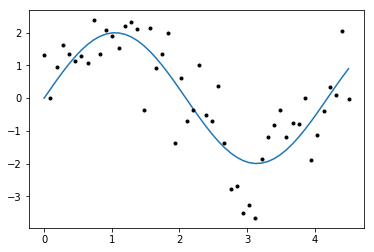

In [6]:
plt.clf()
f_x, f_y = f(50)
plt.plot(f_x, f_y)
x, y = sample(50)
plt.plot(x, y, 'k.')

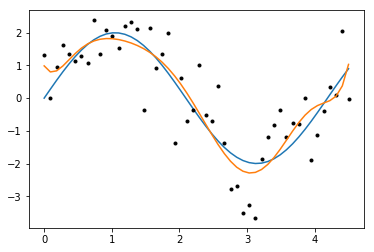

In [7]:
model = fit_polynomial(x, y, 8)
p_y = apply_polynomial(model, x)
plt.plot(f_x, f_y)
plt.plot(x, y, 'k.')
plt.plot(x, p_y)

## Ćwiczenie 1 [2 pkt]

W idealnym świecie mielibyśmy dostęp do procesu generowania danych i moglibyśmy znaleźć optymalny model (a przynajmniej wybrać stopień wielomianu w regresji liniowej) oraz oszacować jego bias i variance.

1. Napisz kod, który dla ustalonego stopnia wielomianu ($K$) liczy bias, variance oraz MSE tego modelu (wielkości te estymujemy podobnie jak w ćwiczeniu 0.).

2. Dla jakich wartości $K$ można powiedzieć że mamy model "High variance/low bias"?

3. Jaka wartość $K$ daje minimum błędu MSE?

Jeśli macie Państwo problem z wymyśleniem wzoru na powyższe wielkości, proszę jeszcze raz przeczytać ze zrozumieniem sekcję o rozkładzie błędu. Kluczowe jest to, że bias liczymy średnio po różnych zestawach danych $D$ - czym są w tym wypadku dane $D$? Jak zrobić kilkadziesiąt/set różnych takich zestawów? Czy rozmiar danych $D$ może ulegać zmianie? (jeśli nie, to proszę ustawić go np. na 43 lub inną liczbę tego rzędu).

Oczekiwany wynik (z dokładnością do wartości) - poziomo $K$, pionowo bias/variance/MSE: 

<img src="figures/L5/L5_1_wynik.png">

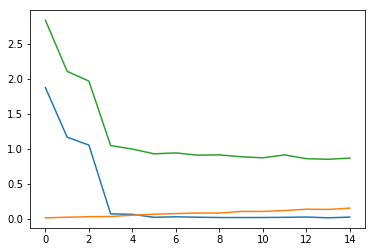

In [151]:
var_avg = []
bias_avg = []
mse_avg = []
N = 50
S = 100
for k in range(0, 15):
    Y_pred = np.zeros(shape=(N, S))
    Y_true = np.zeros(shape=(N, S))
    for i in range(N):
        x, Y_true[i] = sample(S)
        model = fit_polynomial(x, Y_true[i], k)
        Y_pred[i] = apply_polynomial(model, x)
        
    y_pred_avg = np.mean(Y_pred, 0)
    y_true_avg = np.mean(Y_true, 0)
    
    var_avg.append(((Y_pred - y_pred_avg)**2).mean())
    bias_avg.append(((y_pred_avg - y_true_avg) ** 2).mean())
    mse_avg.append(((Y_pred - Y_true)**2).mean())

plt.plot(range(0, 15), bias_avg)
plt.plot(range(0, 15), var_avg)
_ = plt.plot(range(0, 15), mse_avg)

### Poziom 2 wtajemniczenia

Ref: https://en.wikipedia.org/wiki/Estimator, http://blog.evjang.com/2016/09/variance-reduction-part1.html

Mówiliśmy o błędzie modelu oraz estymatora całkowitego kosztu. Bias-variance dilemma dotyczy **dowolnej** estymacji!

Przykłady:

* $mean(x_1, \ldots, x_n) = \overline{x} = \frac{1}{n} \sum x_i$ - estymacja średniej z próby,
* $s^2(x_1, \ldots, x_n) = \frac{1}{n-1} \sum (x_i - \overline{x})^2$ - estymacja wariancji z próby.

Wtedy także zachodzi ($\hat{\theta}$ - oznaczenie estymatora):

$MSE(\hat{\theta}(X)) = var(\hat{\theta}) +  (B(\hat{\theta}))^2$

(Uwaga dodatkowa: powyższe estymatory to tzw. estymatory nieobciążone, w ich wypadku można wykazać, że bias wynosi zero, natomiast variance maleje wraz ze wzrostem liczby przykładów w próbie; ale możemy też wziąć obciążony estymator wariancji $s^2(x_1, \ldots, x_n) = \frac{1}{n} \sum (x_i - \overline{x})^2$ - wtedy średnio podaje on nieprawdziwą wartość, czyli bias $>0$).

Estymatorem też są dowolne metody Monte Carlo, np. estymujące prawdopodobieństwo wygrania w Monty Hall lub powierzchnie figury. Podobnie jak w machine learningu, istnieją sposoby zmniejszenia wariancji. Np. w metodach Monte Carlo estymujących wartość funkcji można samplować nie losowe punkty, ale pary punktów na przeciwko siebie względem środka.

<img width=300 src="figures/L5/mc_target.png">
<img width=300 src="figures/L5/mc_norm.png">
<img width=300 src="figures/L5/mc_ant.png">

## Cross validation

Wróćmy teraz do rzeczywistości - nie mamy możliwości sztucznego dolosowywania danych, mamy tylko jeden zbiór $D$ i musimy przy jego pomocy nauczyć model oraz wyestymować jego skuteczność.

Rozważany wcześniej estymator ``Empirical loss`` ma dużą wariancję, ponieważ rozmiar zbioru testowego (oznaczany zgodnie z powyższymi uwagami przez $N$) jest stosunkowo mały, a w związku z tym jest duża szansa, że "pechowo" źle się dobrał. Z drugiej strony zwiększenie rozmiaru zbioru testowego sprawi, że zmniejszy się rozmiar zbioru trenującego, przez co gorzej się nauczymy. 

Aby zmniejszyć wariancję estymatora, możemy wylosować kilka podziałów i uśrednić. W wypadku cross validation robimy jeden duży podział - dzielimy cały zbiór na $k$ rozłącznych podzbiorów i potem $k$ razy zbiór trenujący składamy z $k-1$ kawałków, a ostatniego używamy jako zbiór testowy. Dzięki temu każdy element $D$ będzie dokładnie raz w zbiorze testowym.

<img src="figures/L3/K-fold_cross_validation_EN.jpg">

Szczególnym przypadkiem jest podejście leave one out, gdzie zbiór testowy jest zawsze jednoelementowy ($k$ jest równe liczbie przykładów).

## Cwiczenie 2 [1 pkt]

Im więcej podziałów w Cross Validation tym mniejczy czy większy variance **estymatora**? A jak zmienia się jego bias? Odpowiedź uzasadnij.

Wg mnie im więcej podziałów, tym większy variance, ponieważ zbiory danych testowych robią się coraz mniejsze. Mogą nie przystawać do rzeczywistego rozkładu i wynik estymacji będzie coraz bardziej zależał od konkretnego zbioru.

Spada natomiast bias, bo modele są coraz bardziej podobne do siebie (trenowane na podobnych zbiorach danych).

# Regularyzacja

Przez regularyzację rozumiemy faworyzowanie "prostszych" hipotez w ramach danego zbioru hipotez (modelu). Mówiąc inaczej, regularyzacja zwiększa bias kosztem wariancji, a więc jej stosowanie ma sens tylko wtedy, gdy przypuszczamy, że to wariancja jest dominującym składnikiem błędu całkowitego.

Przykładami regularyzacji są:
* L1/L2 - "prostsze" hipotezy to te o małych wagach,
* zmniejszenie wymiaru wielomianu w regresji liniowej.

## Regularyzacja - podejście "praktyczne"

Chcemy uniemożliwić regresji dopasowanie wielomianu zbyt idealnie do danych treningowych (patrz wykres overfitted_model). Nie chcemy sztucznie ograniczać wymiaru wielomianu. Sensowne wydaje się ograniczenie norm wag:

$$ C(M) = \sum_i ( f(\mathbf{x_i}) - y_i)^2 + \lambda ||\mathbf{w}||_2^2 $$

Ograniczenie wag sprawi, że wyliczony przez regresję wielomian będzie miał łagodniejszy przebieg i tym samym mniej zoverfituje.

### Kontury funkcji kosztu

Poziomice C(M), osobno dla 2 członów (MSE oraz regularyzacja). Prawy wykres to L1, lewy to L2.

<img width=600 src="figures/L5/cont.png">

### Regularyzacja a podejście Bayesowkie

W rozumieniu Bayesowskim regularyzacja L1/L2 odpowiada wzięciu a priori rozkładu na wagach $\mathbf{w}$, który faworyzuje wagi o normie bliskiej zero. Jeśli nasz prior odpowiada rzeczywistości, to błąd na zbiorze testującym będzie niższy niż w przypadku, kiedy nie stosujemy regularyzacji.

Faktycznie - w rzeczywistości często opisywane funkcjami zjawiska są wytłumaczalne przez małą ilość zmiennych, dlatego regularyzacja L1 bywa skuteczna. Cały problem polega na tym, że nie wiemy, które cechy są istotne, więc do modelu podajemy jak najpełniejszy opis (długi wektor cech), natomiast model z regularyzacją L1 wybiera za nas (i jednocześnie waży!) te najistotniejsze.

## Cwiczenie 3 [1 pkt]

Pokaż, że logposterior ($log p(\theta | X, y)$) dla regresji liniowej ma taką postać jak $C(M)$.

### Inne przykłady regularyzacji

* Model najbliższych sąsiadów (k-NN)

* Estymacja gęstości (szerokość jądra funkcji bazowych)

* Dropout w sieciach neuronowych